73


INFO (theano.gof.compilelock): Waiting for existing lock by process '27780' (I am process '1146')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/jgs/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-stretch-sid-x86_64-3.7.1-64/lock_dir
Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains: 100%|██████████| 2800/2800 [00:01<00:00, 2566.41draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains: 100%|██████████| 2800/2800 [00:01<00:00, 2708.94draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight proble

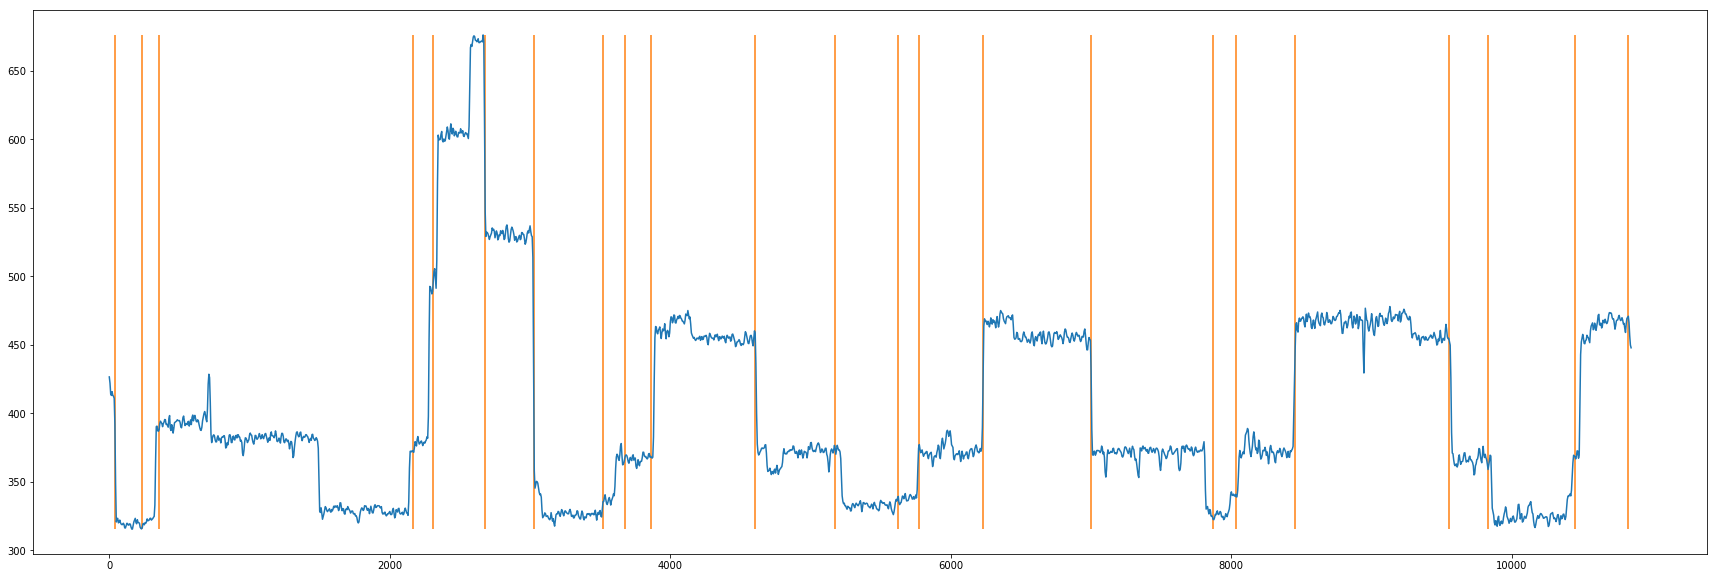

In [3]:
import numpy as np
import seaborn as sns
import pymc3 as pm
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

ts = pd.read_table('/home/jgs/jupyter/ont_data_test/flipDataFinal_1.txt', names=['current'])

def switch_test(current, mu_p, sd_p,sample_num=1000, threads=4):
    with pm.Model() as switch_point:
        #sps = pm.Poisson('points', 0)
        #ragnes = np.random.randint(years.min(),years.max(), sps)
        current_data = current[0]
        time = current[1]
        switchpoint = pm.DiscreteUniform('switchpoint', lower=time.min(), upper=time.max())

        # Priors for pre- and post-switch rates number of disasters
        early_rate = pm.Normal('early_rate', mu=mu_p, sd=sd_p)
        late_rate = pm.Normal('late_rate', mu=mu_p, sd=sd_p)

        # Allocate appropriate Poisson rates to years before and after current
        rate = pm.math.switch(switchpoint >= time, early_rate, late_rate)

        disasters = pm.Normal('current', mu=rate, sd=70, observed=current_data)
        if sample_num > 5000:
            trace = pm.sample(5000, cores=threads)
        elif sample_num < 200:
            trace = pm.sample(200, cores=threads)
        else:
            trace = pm.sample(sample_num, cores=threads)
            
    return [trace['switchpoint'].mean(), trace['switchpoint'].std(),
            [trace['early_rate'].mean(), trace['early_rate'].std()],
            [trace['late_rate'].mean(), trace['late_rate'].std()]]

ts_n = (ts-ts.mean())/ts.std()
ts_e = ts_n*70 + 400
tr = ts_e.rolling(window=10, center=True, min_periods=1)
tss = tr.mean()[::5]
tsv = tr.var()

size_r = 30
cut_r = [tss[i:i+2*size_r] for i in range(0, len(tss) ,size_r)]
def region(df, size=20, vc=20):
    if df.std().values > vc:
        size_r = size//2
        tmp = [[df[i:i+2*size_r].values.T, np.array(df[i:i+2*size_r].index)] for i in range(0, len(df),size_r)]
        for i in tmp:
            return switch_test(i, 400, 70, size_r)
    else:
        df = [df.values.T, np.array(df.index)]
        return switch_test(df, 400, 70, size)
#[np.std(i[0]) for i in cut_r]
#test_r = [switch_test(i, 40, 20) for i in cut_r];
print(len(cut_r))
test_r = [region(i, 30, 10) for i in cut_r];

cutoff = 50; pc = 0.5
vl_r = [i[0] for i in test_r if (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],20, i[3][0],i[3][1],20).pvalue < pc)]
vs_r = [i[1] for i in test_r if (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],20, i[3][0],i[3][1],20).pvalue < pc)]
plt.figure(figsize=(30, 10))
plt.plot(tss)
plt.vlines(vl_r, tss.min(), tss.max(), color='C1')
for i in [i for i in test_r if i[1] < (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],20, i[3][0],i[3][1],20).pvalue < pc)]:
    plt.fill_betweenx(y=[int(tss.min()), int(tss.max())], x1=i[0] - i[1], x2=i[0] + i[1], alpha=0.5, color='C1');

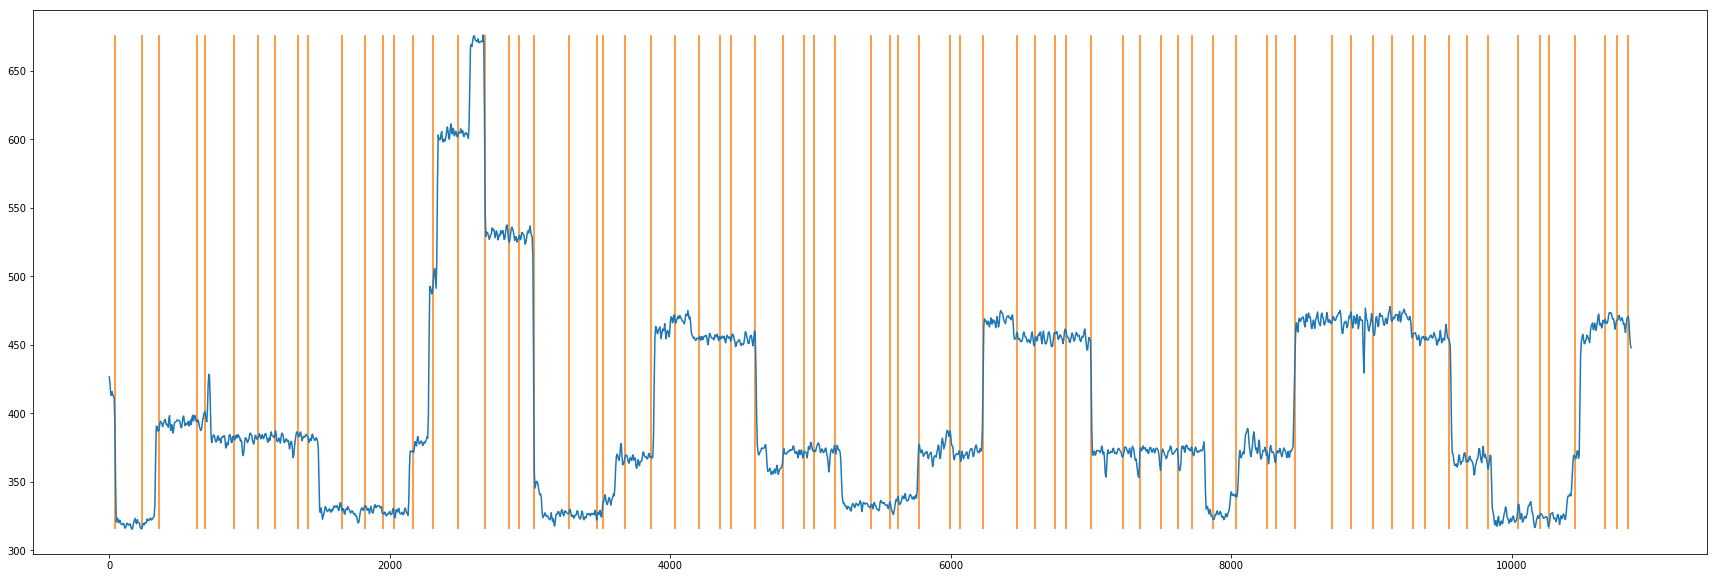

In [30]:
cutoff = 1000; pc = 1
vl_r = [i[0] for i in test_r if (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],20, i[3][0],i[3][1],20).pvalue < pc)]
vs_r = [i[1] for i in test_r if (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],20, i[3][0],i[3][1],20).pvalue < pc)]
plt.figure(figsize=(30, 10))
plt.plot(tss)
plt.vlines(vl_r, tss.min(), tss.max(), color='C1')
for i in [i for i in test_r if i[1] < (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],20, i[3][0],i[3][1],20).pvalue < pc)]:
    plt.fill_betweenx(y=[int(tss.min()), int(tss.max())], x1=i[0] - i[1], x2=i[0] + i[1], alpha=0.5, color='C1');

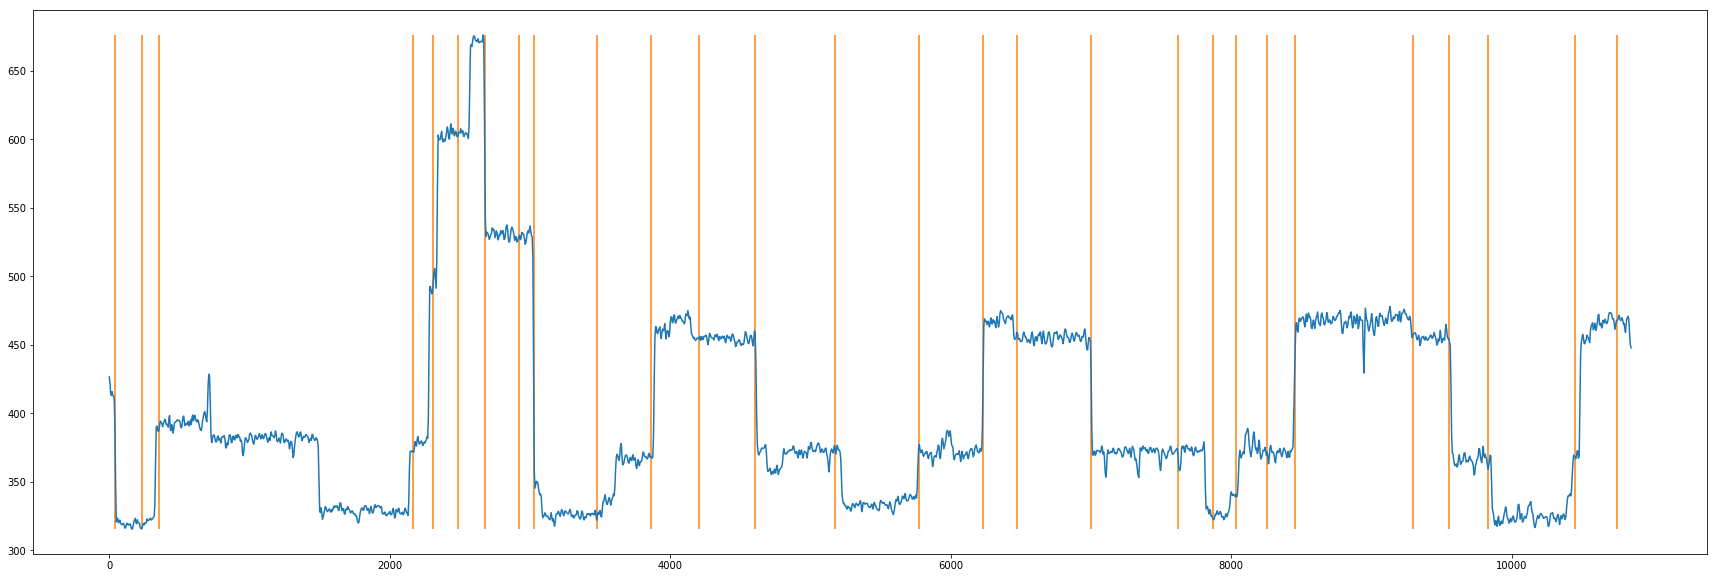

In [39]:
cutoff = 100; pc = 0.3
vl_r = [i[0] for i in test_r if (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],size_r, i[3][0],i[3][1],size_r).pvalue < pc)]
vs_r = [i[1] for i in test_r if (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],size_r, i[3][0],i[3][1],size_r).pvalue < pc)]
plt.figure(figsize=(30, 10))
plt.plot(tss)
plt.vlines(vl_r, tss.min(), tss.max(), color='C1')
for i in [i for i in test_r if i[1] < (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],size_r, i[3][0],i[3][1],size_r).pvalue < pc)]:
    plt.fill_betweenx(y=[int(tss.min()), int(tss.max())], x1=i[0] - i[1], x2=i[0] + i[1], alpha=0.5, color='C1');

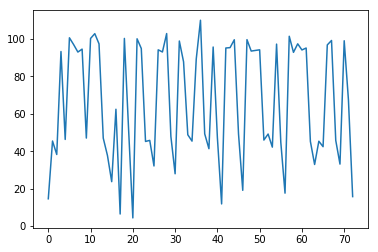

In [18]:
plt.plot([i[1] for i in test_r])

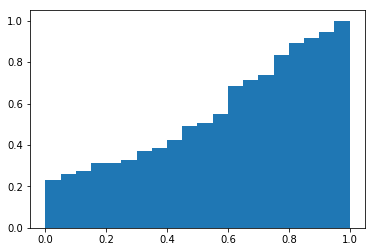

In [28]:
plt.hist([sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],20, i[3][0],i[3][1],20).pvalue for i in test_r],bins=20, density=True, cumulative=True);

In [11]:
import numpy as np
import seaborn as sns
import pymc3 as pm
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

ts = pd.read_table('/home/jgs/jupyter/ont_data_test/flipDataFinal_1.txt', names=['current'])
ts_n = (ts-ts.mean())/ts.std()
ts_e = ts_n*70 + 400
tr = ts_e.rolling(window=10, center=True, min_periods=1)
tss = tr.mean()[::5]
tsv = tr.var()

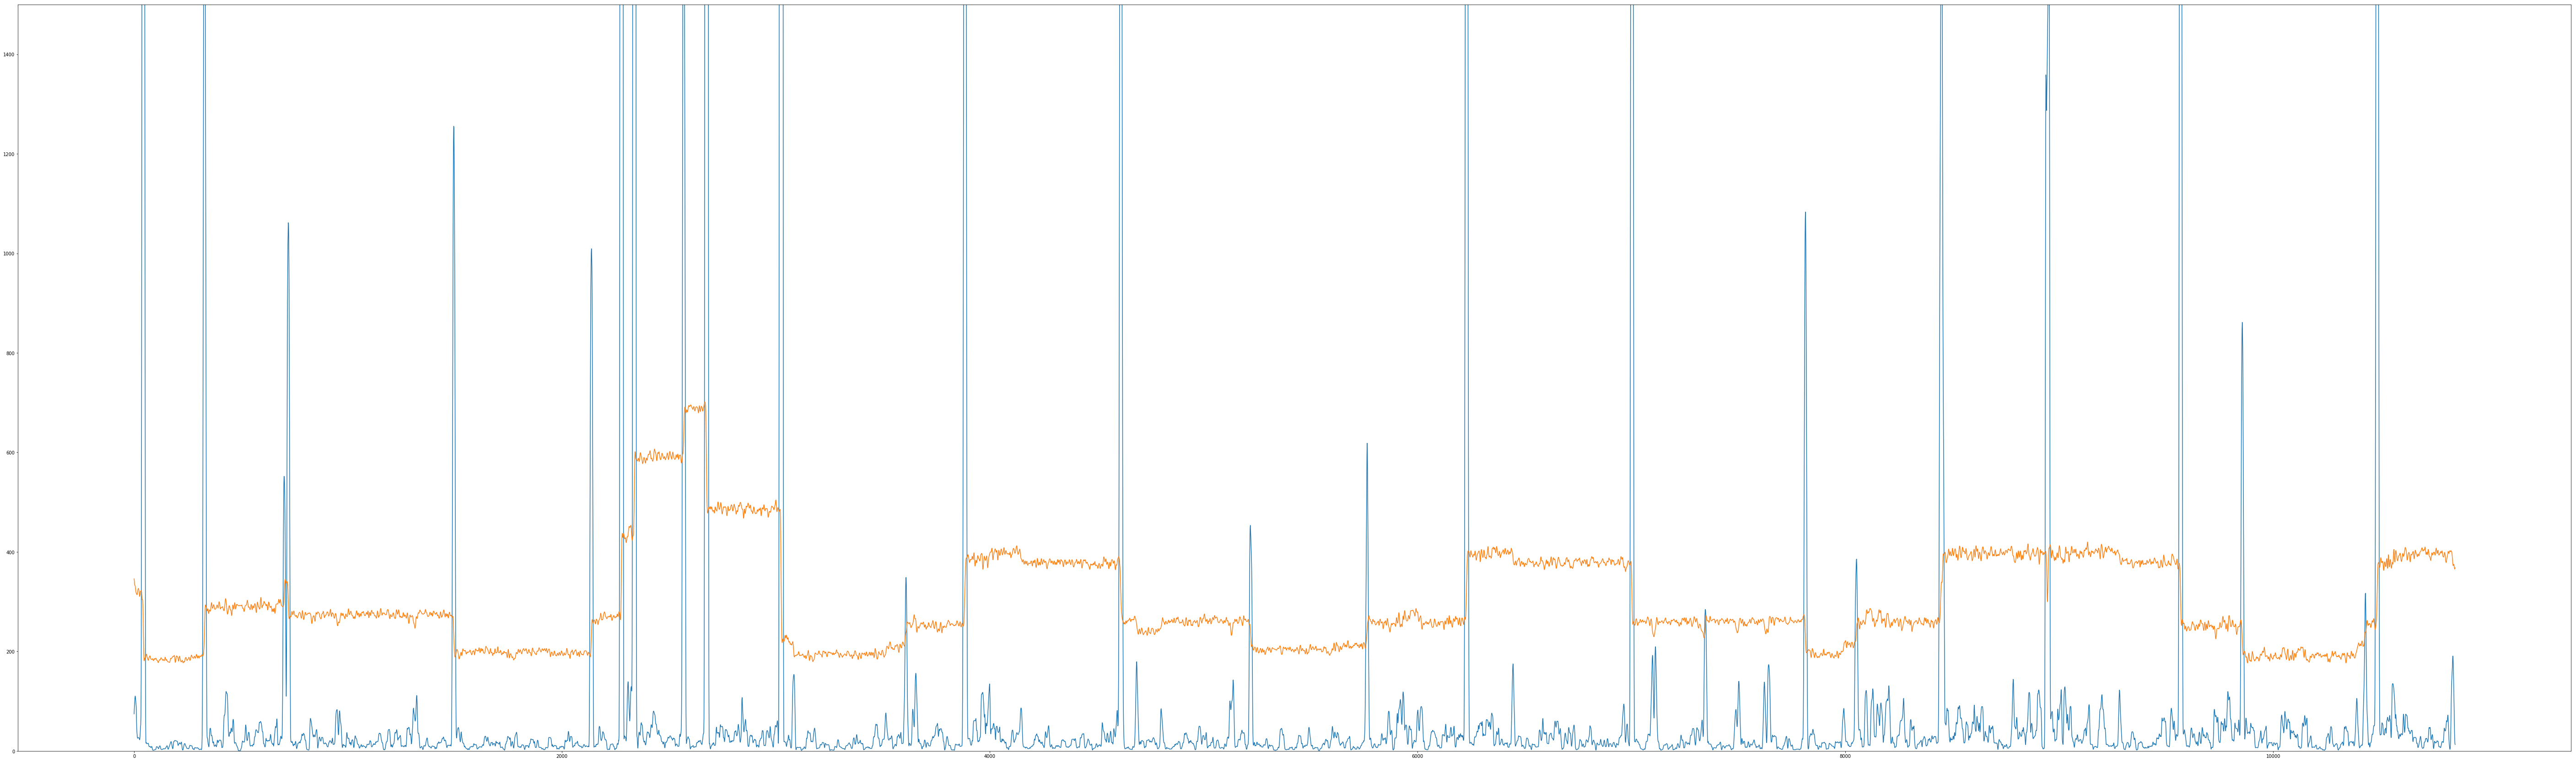

In [62]:
p = [0,100]
yl = [0, 1000]
ts_e = ts_n*p[1] + p[0]
tsv_n =ts_e.rolling(window=20, center=True, min_periods=1).var()

plt.figure(figsize=(100, 30))

#plt.plot(s)
plt.plot(tsv_n.values)
#plt.plot(s)
plt.ylim((0,1500));
#s = list(data['10 Min Std Dev'])
#new_signal = np.convolve(s, sinc_func)
plt.plot(ts_n.values*100 + 300)
#ax = ts_n.plot(figsize=(100, 30));

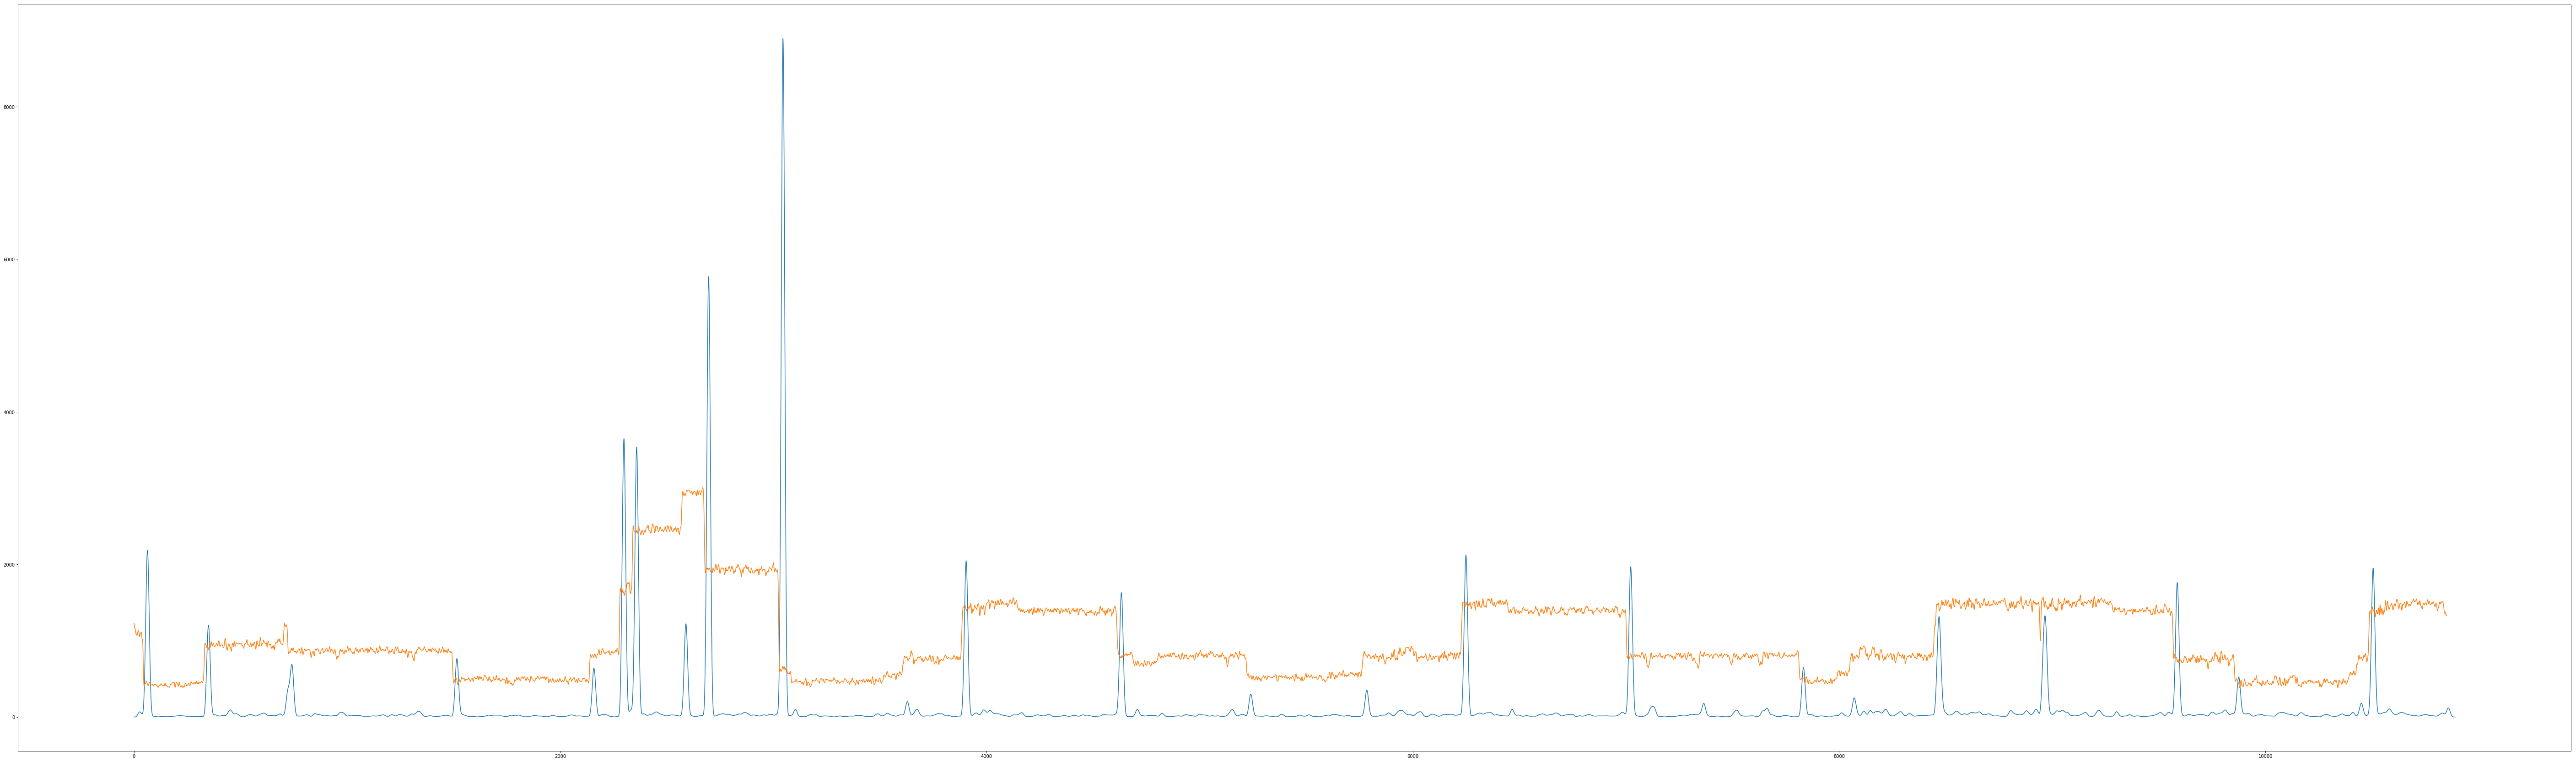

In [53]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import numpy as np
import pandas as pd
import scipy

from scipy import signal

fc = 0.0001
b = 0.1
N = int(np.ceil((4 / b)))
if not N % 2: N += 1
n = np.arange(N)
 
sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
sinc_func = sinc_func * window
sinc_func = sinc_func / np.sum(sinc_func)
#tsv_n.plot(figsize=(100, 30), ylim=yl)
#tsv_n.apply(lambda x: np.convolve(x, sinc_func)).plot(figsize=(100, 30), ylim=yl);
s = list(tsv_n.current.values)
new_signal = np.convolve(s, sinc_func)
plt.figure(figsize=(100, 30))

#plt.plot(s)
plt.plot(new_signal)
#plt.plot(s)
#plt.ylim((-10,10));
#s = list(data['10 Min Std Dev'])
#new_signal = np.convolve(s, sinc_func)
plt.plot(ts_n.values*500 + 1000)
#ax = ts_n.plot(figsize=(100, 30));

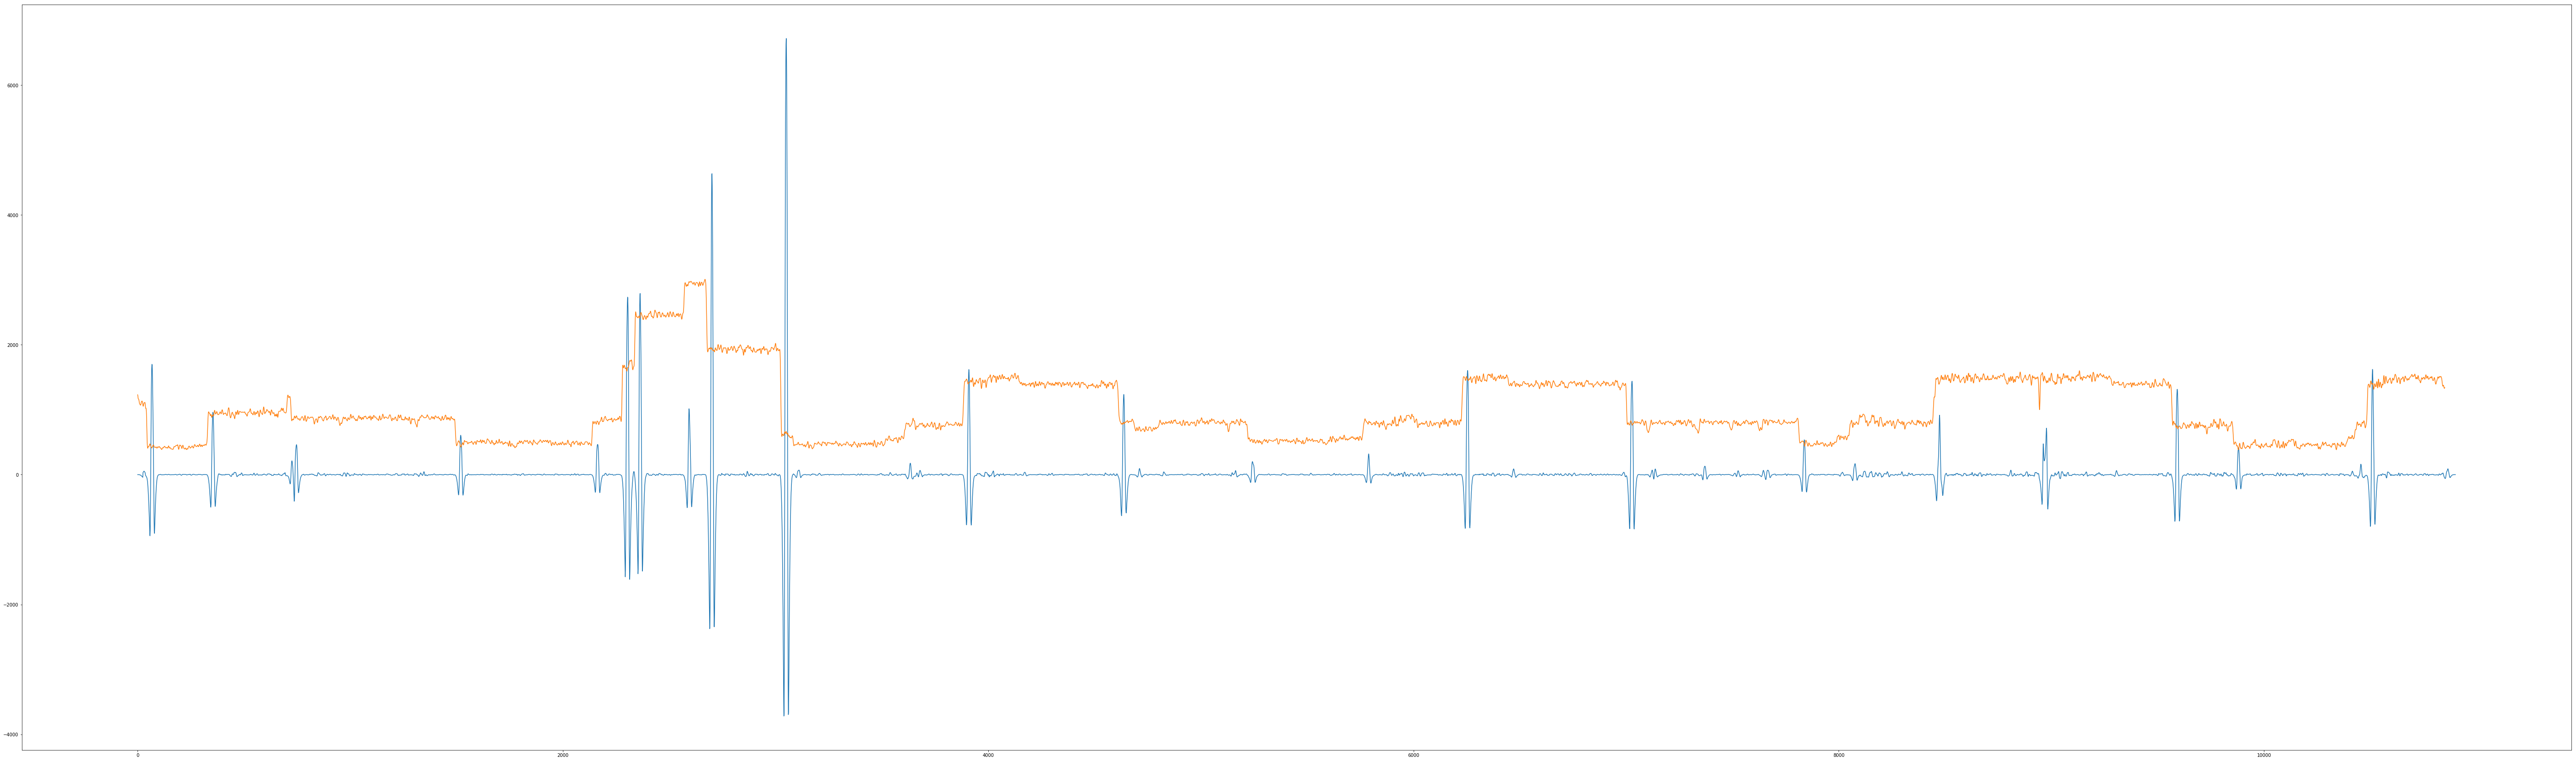

In [52]:
fc = 0.0001
b = 0.08
N = int(np.ceil((4 / b)))
if not N % 2: N += 1
n = np.arange(N)
 
sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
window = np.blackman(N)
sinc_func = sinc_func * window
sinc_func = sinc_func / np.sum(sinc_func)

# reverse function
sinc_func = -sinc_func
sinc_func[int((N - 1) / 2)] += 1

s = list(tsv_n.current.values)
new_signal = np.convolve(s, sinc_func)
plt.figure(figsize=(100, 30))
plt.plot(new_signal)
#plt.plot(s)
#plt.ylim((-10,10));
#s = list(data['10 Min Std Dev'])
#new_signal = np.convolve(s, sinc_func)
plt.plot(ts_n.values*500 + 1000)
#ax = ts_n.plot(figsize=(100, 30));